<a href="https://colab.research.google.com/github/BillPapakyriakou/MachineLearning/blob/main/MachineLearning1A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

imports + load dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Fashion MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


organisze data

In [4]:

# Split data into data and labels
X = fashion_mnist.data.astype('float32')
y = fashion_mnist.target.astype('int64')

# Split into train data and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply max pooling gradually to obtain 4x4 images
X_train_pooled = X_train.reshape(-1, 28, 28)
X_test_pooled = X_test.reshape(-1, 28, 28)

# Apply max pooling from 28x28 to 14x14
X_train_pooled = X_train_pooled.reshape(-1, 14, 2, 14, 2).max(axis=(2, 4))
X_test_pooled = X_test_pooled.reshape(-1, 14, 2, 14, 2).max(axis=(2, 4))

# Apply max pooling from 14x14 to 7x7
X_train_pooled = X_train_pooled.reshape(-1, 7, 2, 7, 2).max(axis=(2, 4))
X_test_pooled = X_test_pooled.reshape(-1, 7, 2, 7, 2).max(axis=(2, 4))

# Apply max pooling from 7x7 to 4x4
""" Needs work done """

# Convert data to vectors
X_train_vectorized = X_train_pooled.reshape(len(X_train_pooled), -1)
X_test_vectorized = X_test_pooled.reshape(len(X_test_pooled), -1)

"""
# Check the shape of X_train_vectorized
print("Shape of X_train_vectorized:", X_train_vectorized.shape)

# Check the shape of X_test_vectorized
print("Shape of X_test_vectorized:", X_test_vectorized.shape)
"""

# Define model parameters
K_VALUES = [1, 3, 5]
C_VALUES = [1, 10, 100]
RBF_VALUES = [0.02, 0.1, 1]
NUM_EPOCHS = 100
BATCH_SIZE = 50

# Create models
models = {}

# ΚNN Classifier
for k in K_VALUES:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_vectorized, y_train)
    models[f'KNN (K={k})'] = knn

# Decision Tree Classifier
dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(X_train_vectorized, y_train)
models['Decision Tree'] = dtc

# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_vectorized, y_train)
models['Random Forest'] = rfc

# Linear SVM Classifier
for c in C_VALUES:
    svm_linear = SVC(kernel='linear', C=c, max_iter=500)
    svm_linear.fit(X_train_vectorized, y_train)
    models[f'Linear SVM (C={c})'] = svm_linear

# SVM with RBF Kernel Classifier
for gamma in RBF_VALUES:
    svm_rbf = SVC(kernel='rbf', gamma=gamma, max_iter=500)
    svm_rbf.fit(X_train_vectorized, y_train)
    models[f'SVM RBF (gamma={gamma})'] = svm_rbf



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-

Configure and create network

In [8]:
# Neural Network (feed-forward)
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(49, 100)  # first hidden layer, 100 neurons
    self.fc2 = nn.Linear(100, 100)  # second hidden layer, 100 neurons
    self.fc3 = nn.Linear(100, 50)  # third hidden layer, 50 neurons
    self.fc4 = nn.Linear(50, len(np.unique(y_train)))  # output layer

    # initialize objects for the activation functions used in this model
    self.leaky_relu = nn.LeakyReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    x = self.leaky_relu(self.fc1(x))  # LeakyReLU for hidden layer 1
    x = self.leaky_relu(self.fc2(x))  # LeakyReLU for hidden layer 2
    x = self.leaky_relu(self.fc3(x))  # LeakyReLU for hidden layer 3
    x = self.fc4(x)
    x = self.softmax(x)  # SoftMax for output layer
    return x


y_train = y_train.values

X_train_tensor = torch.tensor(X_train_vectorized)
y_train_tensor = torch.tensor(y_train)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


Train Network

In [9]:

# Create and train Neural Network
model_nn = NeuralNetwork()

# Loss and optimizer
criterion = nn.NLLLoss()  #  Negative Log Likelihood loss function
optimizer = optim.Adam(model_nn.parameters())  # Adam optimizer for training

losses = []

for epoch in range(NUM_EPOCHS):
    for inputs, labels in train_loader:
        optimizer.zero_grad()             # zero the gradients
        outputs = model_nn(inputs)
        loss = criterion(outputs, labels) # loss
        loss.backward()                   # calculate gradients = backward pass
        optimizer.step()                  # update weights
    losses.append(loss.item())

Network Evaluation

Accuracy of the network on the test images: 81.39%
Total number of parameters in the network: 20660


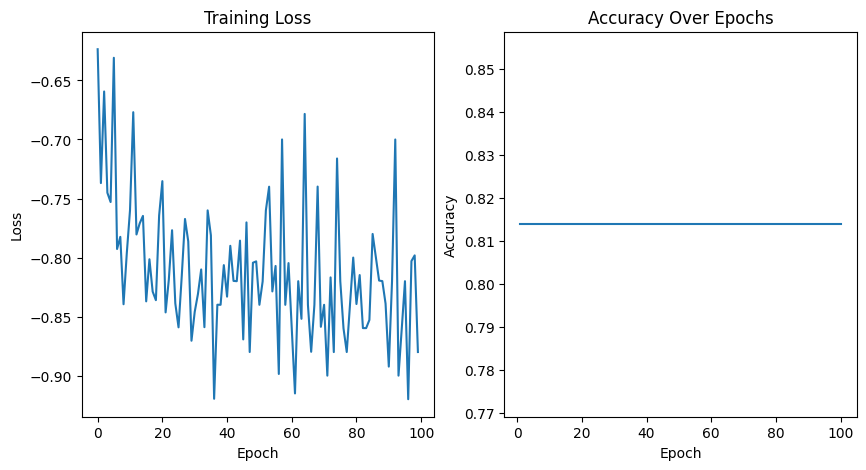

In [42]:
# Network Evaluation

# Initialize list to store accuracies at each epoch
accuracies = []

# Loop through epochs
for epoch in range(NUM_EPOCHS):

    # Set model to evaluation mode
    model_nn.eval()

    # Initialize variables to count correct predictions and total samples
    correct = 0
    total = 0

    # Iterate over test data
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model_nn(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate accuracy for the current epoch
    accuracy = correct / total

    # Append accuracy to the list
    accuracies.append(accuracy)

# print nn accuracy
print(f'Accuracy of the network on the test images: {100 * accuracy:.2f}%')

# print nn parameters
total_params = sum(p.numel() for p in model_nn.parameters() if p.requires_grad)
print(f'Total number of parameters in the network: {total_params}')


# print loss function value and accuracy depending on the number of epochs

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies)
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()